# Classifying Cats and Dogs by Image Using CNN, 95% Accuracy

In this project, we will be classifying images of cats and dogs using the Keras API and a Convolutional Neural Network. To train and test this model, we will be using 10,000 colored images (5,000 of each, cats and dogs), which I sourced from superdatascience.com/machine-learning. 

In our working directory, we have a folder named "dataset," which contains both the training and test set images. The images have been sorted by category within the training_set and test_set sub-directories, and will flow from their respective directories into the model. There is an 80-20 split between the training and test sets, each set containing equal parts cat and dog images.

Let's start by importing the libraries that we'll be using.

In [1]:
%matplotlib inline

import sys
import numpy as np

# We'll make use of an AMD GPU by using PlaidML as our back-end, rather that Tensorflow
import plaidml.keras as pk
pk.install_backend()

from keras import models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from matplotlib.image import imread
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

from sklearn.metrics import confusion_matrix

## Initializing the CNN

Let's jump straight into building our CNN.

In [2]:
# Initialize CNN
classifier = Sequential()

The structure of this network will be as follows: we will have five convolutional layers, followed by a flattening layer and two fully-connected dense layers. The model will also make use of batch normalization along the "color" channel of our image tensors, rectified linear unit activation ("relu"), and 2x2 max pooling between convolutional layers, as well as a 50% dropout for our fully-connected layers.

Given that this will be a binary classification, the output layer will have a sigmoid activation, and our loss will be measured by binary cross-entropy.

In [3]:
# 1st convolution
classifier.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128,128,3)))
classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd convolution
classifier.add(Conv2D(filters=128, kernel_size=(3, 3)))
classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd convolution
classifier.add(Conv2D(filters=256, kernel_size=(3, 3)))
classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# 4th convolution
classifier.add(Conv2D(filters=256, kernel_size=(3, 3)))
classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# 5th convolution
classifier.add(Conv2D(filters=512, kernel_size=(3, 3)))
classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# flatten
classifier.add(Flatten())

# full connection w/ dropout  
classifier.add(Dense(units=1024))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(units=256))
classifier.add(Activation('relu')) 
classifier.add(Dropout(0.5))

# output layer
classifier.add(Dense(units=1))
classifier.add(Activation('sigmoid'))

INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"


We also need consider our learning rate. There is a trade-off between the learning and the time it will take to train our model, so we do not want to set it too low, otherwise our model will take a very long time to train. However, setting the learning rate to be too high can stop the gradient decent algorithm from effectively minimizing loss. To adjust for this, we will start with a higher learning rate and set it to reduce by half if our loss does not improve for 3 epochs, with a minimum learning rate of 0.00001.

In [4]:
# adjust learning rate for plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, 
                                            verbose=2, factor=0.5, min_lr=0.00001)

## Compile the Model and Set Error Metrics and Optimizer

Now we will compile our model. We will be using the adam optimizer function, and we will track the binary cross-entropy and accuracy as our model trains to determine how well it is fitting the data.

In [5]:
# compile model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Early Stopping and Model Saving

While our model is running, we will also be saving its parameters each time a new "best" is acheived.

In [6]:
best_model = ModelCheckpoint('cats_v_dogs.h5', monitor='val_acc', verbose=2, 
                             save_best_only=True, mode='max')

It is often case that neaural networks will continue to train despite having not improved for many epochs, which can be time-consuming and expensive, so we will set early-stopping conditions for the training of our model: if the loss does not improve by at least 1e-10 for 25 epochs, then training will stop, and the best model will be saved.

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-10, 
                               patience=25,restore_best_weights=True)

## Image Preprocessing and Augmentation

To further increase our model's predictive capability, we will be augmenting our data set by randomly transforming the image data to account for the zoom of the image, height and width shifts, and flipping the image horizontally. By doing this, we increase the model's ability to adapt to a wider range of variability among the two classes, and thus reduce overffitting and increase prediction accuracy.

To accomplish this task, we will create an instance of the ImageDataGenerator class, and have it apply the random transformations to our images as they are read from their directories.

In [8]:
# Image processing, data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   height_shift_range=.1,
                                   width_shift_range=.1,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size=(128, 128), 
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size=(128, 128), 
                                            batch_size=32,
                                            class_mode='binary',
                                            shuffle=True)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Fitting the Model

In [9]:
model = classifier.fit_generator(training_set,
                         steps_per_epoch=8000/32,
                         epochs=100,
                         validation_data=test_set,
                         validation_steps=2000,
                         verbose=1,
                         callbacks=[learning_rate_reduction,best_model,early_stopping]
                         )

Epoch 1/100


INFO:plaidml:Analyzing Ops: 773 of 839 operations complete


250/250 [==============================] - 225s 901ms/step - loss: 0.8539 - acc: 0.5587 - val_loss: 0.7783 - val_acc: 0.5002

Epoch 00001: val_acc improved from -inf to 0.50022, saving model to cats_v_dogs.h5
Epoch 2/100
250/250 [==============================] - 224s 895ms/step - loss: 0.6420 - acc: 0.6400 - val_loss: 0.6291 - val_acc: 0.6570

Epoch 00002: val_acc improved from 0.50022 to 0.65699, saving model to cats_v_dogs.h5
Epoch 3/100
250/250 [==============================] - 223s 892ms/step - loss: 0.6004 - acc: 0.6846 - val_loss: 0.8406 - val_acc: 0.4950

Epoch 00003: val_acc did not improve from 0.65699
Epoch 4/100
250/250 [==============================] - 223s 893ms/step - loss: 0.5721 - acc: 0.7082 - val_loss: 0.5353 - val_acc: 0.7563

Epoch 00004: val_acc improved from 0.65699 to 0.75635, saving model to cats_v_dogs.h5
Epoch 5/100
250/250 [==============================] - 225s 898ms/step - loss: 0.5225 - acc: 0.7529 - val_loss: 0.6026 - val_acc: 0.6454

Epoch 00005: val_

250/250 [==============================] - 223s 893ms/step - loss: 0.0774 - acc: 0.9716 - val_loss: 0.2063 - val_acc: 0.9240

Epoch 00040: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00040: val_acc did not improve from 0.95108
Epoch 41/100
250/250 [==============================] - 224s 895ms/step - loss: 0.0730 - acc: 0.9743 - val_loss: 0.1575 - val_acc: 0.9409

Epoch 00041: val_acc did not improve from 0.95108
Epoch 42/100
250/250 [==============================] - 223s 894ms/step - loss: 0.0697 - acc: 0.9748 - val_loss: 0.1505 - val_acc: 0.9476

Epoch 00042: val_acc did not improve from 0.95108
Epoch 43/100
250/250 [==============================] - 223s 892ms/step - loss: 0.0675 - acc: 0.9735 - val_loss: 0.1535 - val_acc: 0.9468

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00043: val_acc did not improve from 0.95108
Epoch 44/100
250/250 [==============================] - 224s 896ms/step - loss: 0.0699 - acc: 

So there we have our 95% accuracy on the test data!

The best model, however, was saved back at epoch 36, with 0.9511 acuuracy on the test set and 0.1373 loss, and though the accuracy showed slight improvement after that, the loss began to diverge, which means we might have been overly patient with our early stopping criteria.

We can see this by plotting the loss v. accuracy below. The red vertical line marks epoch 36, the point at which the model saved. Particularly, with the loss we can see a significant gap between the training data and validation data emerging, which is a sign that the model was beginning to overfit.

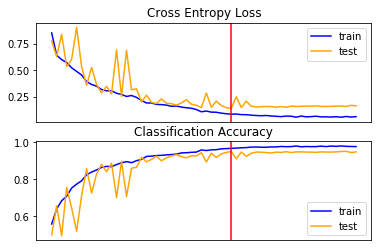

In [23]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(model.history['loss'], color='blue', label='train')
plt.plot(model.history['val_loss'], color='orange', label='test')
plt.axvline(36, color='red')
plt.xticks([])
plt.legend()
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(model.history['acc'], color='blue', label='train')
plt.plot(model.history['val_acc'], color='orange', label='test')
plt.axvline(36, color='red')
plt.legend()

plt.xticks([])
plt.show()

## Predict Image

Now let's put our madel to the test!

I randomly selected two stock images from Google to see if the model could predict outside of the data we have use for training and validation, and I've prepared two functions to facilitate testing: one to prepare the images, and one to feed them into the model.

In [13]:
def prepare_image(image_file):
    img = load_img(image_file, target_size=(128,128))
    img = img_to_array(img)
    img = img.reshape(1,128,128,3)
    img = img.astype('float32')
    img = img * (1/255)
    
    return img

def cat_dog_classifier(image_file):
    img = prepare_image(image_file)
    
    model = load_model('cats_v_dogs.h5')
    result = model.predict(img)
    
    display_img = imread(image_file)
    plt.imshow(display_img)
    
    if result[0] > .5:
        print('\nIT\'S A DOG')
    else:
        print('\nIT\'S A CAT')

Now we only need to feed the file path for the images to cat_dog_classifier() and see the results!


IT'S A DOG


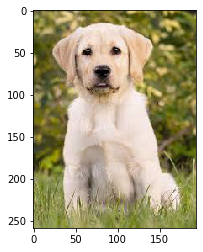

In [14]:
image_file = 'new_dog.jpg'

cat_dog_classifier(image_file)


IT'S A CAT


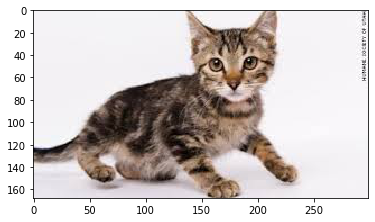

In [15]:
image_file = 'new_cat.jpg'

cat_dog_classifier(image_file)

## A Closer Look at Intermediate Activations

In [16]:
image = prepare_image(image_file)

layer_outputs = [layer.output for layer in classifier.layers[:20]]
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs)

In [17]:
activations = activation_model.predict(image)

In [18]:
first_layer_activation = activations[0]

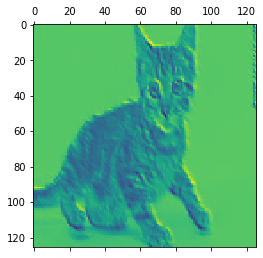

In [19]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

/Users/nastory/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


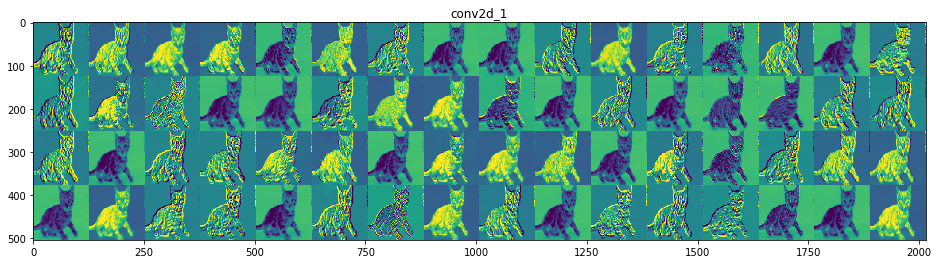

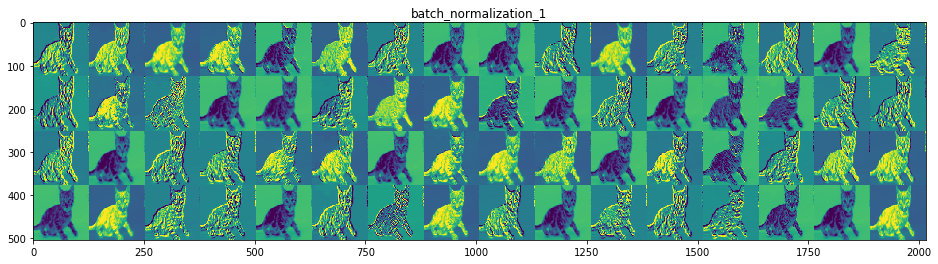

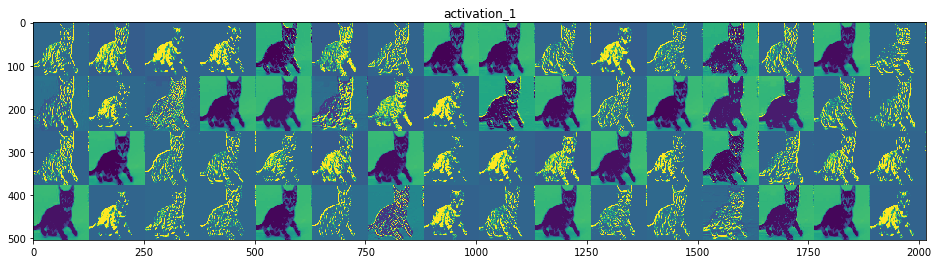

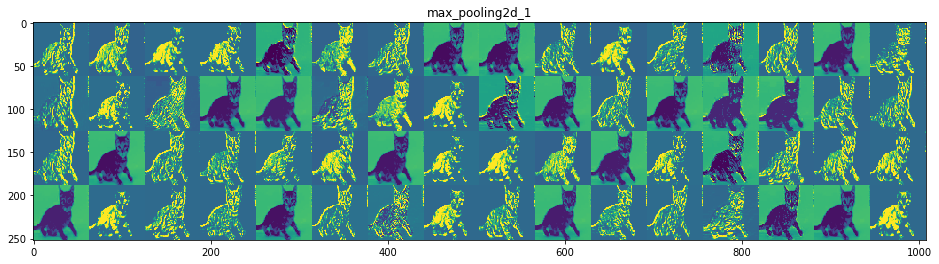

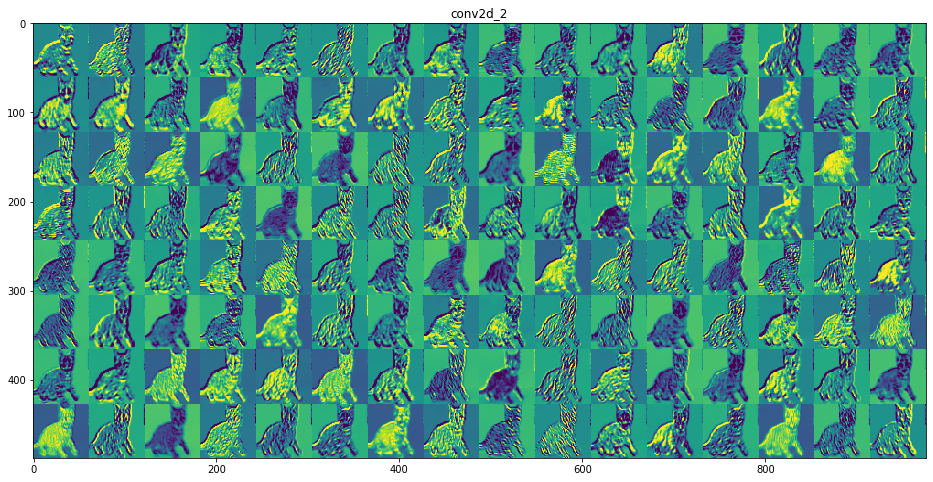

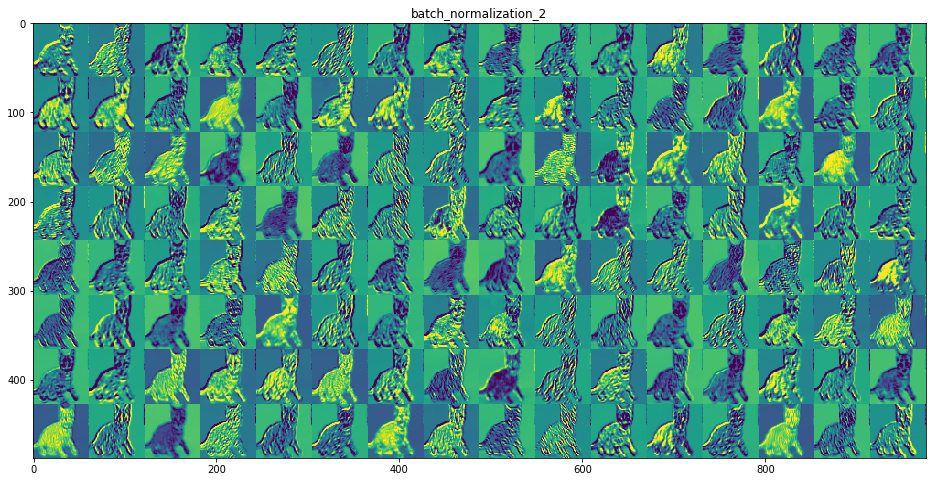

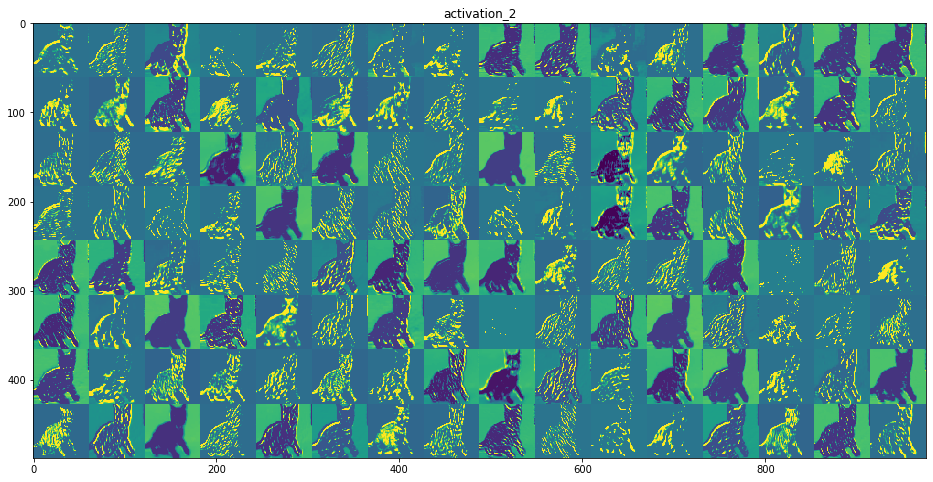

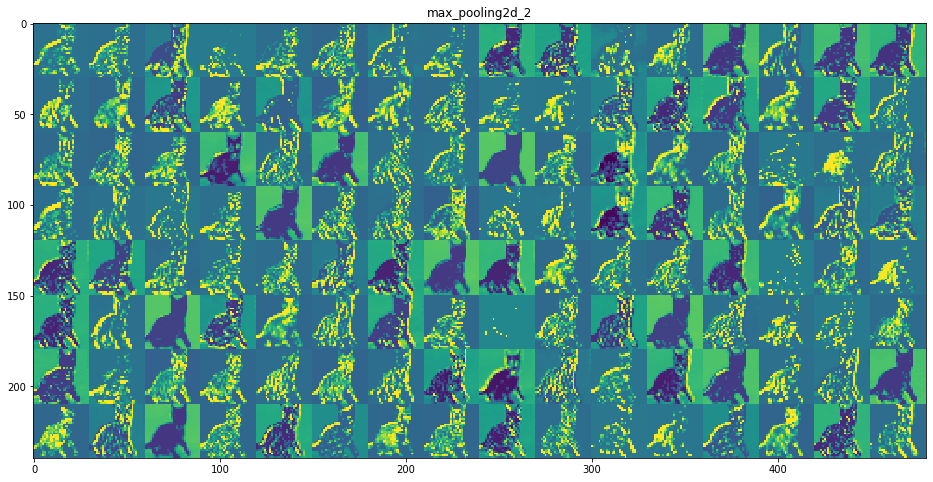

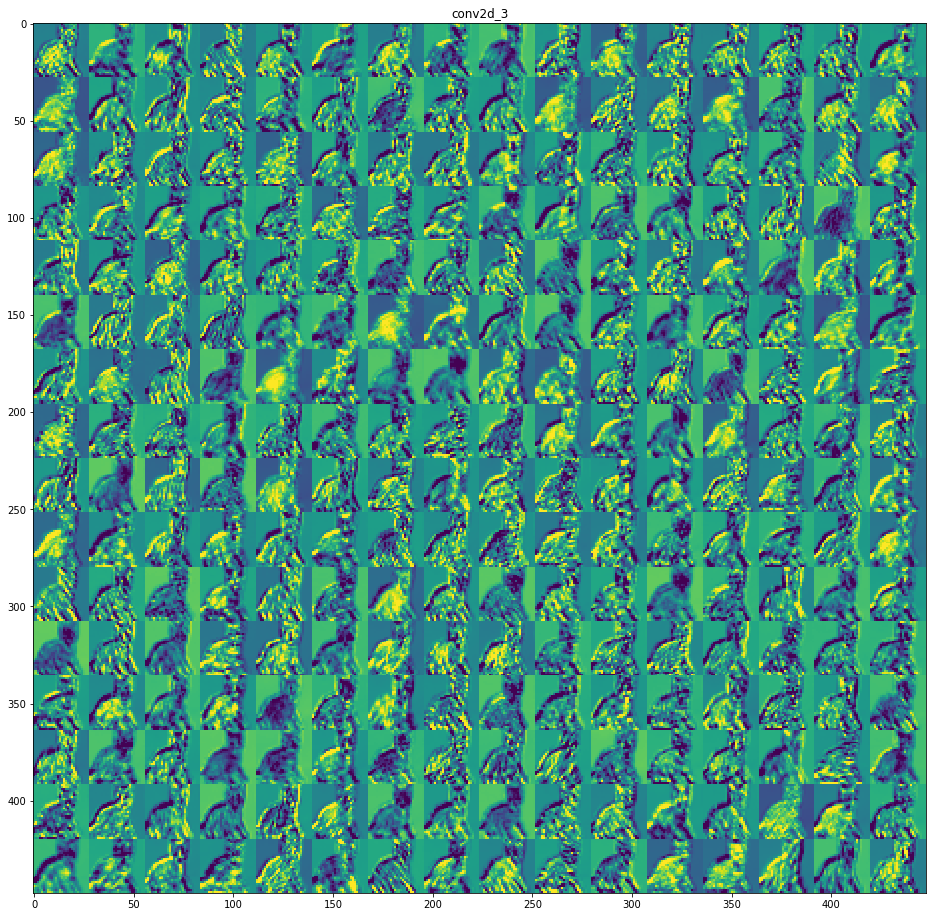

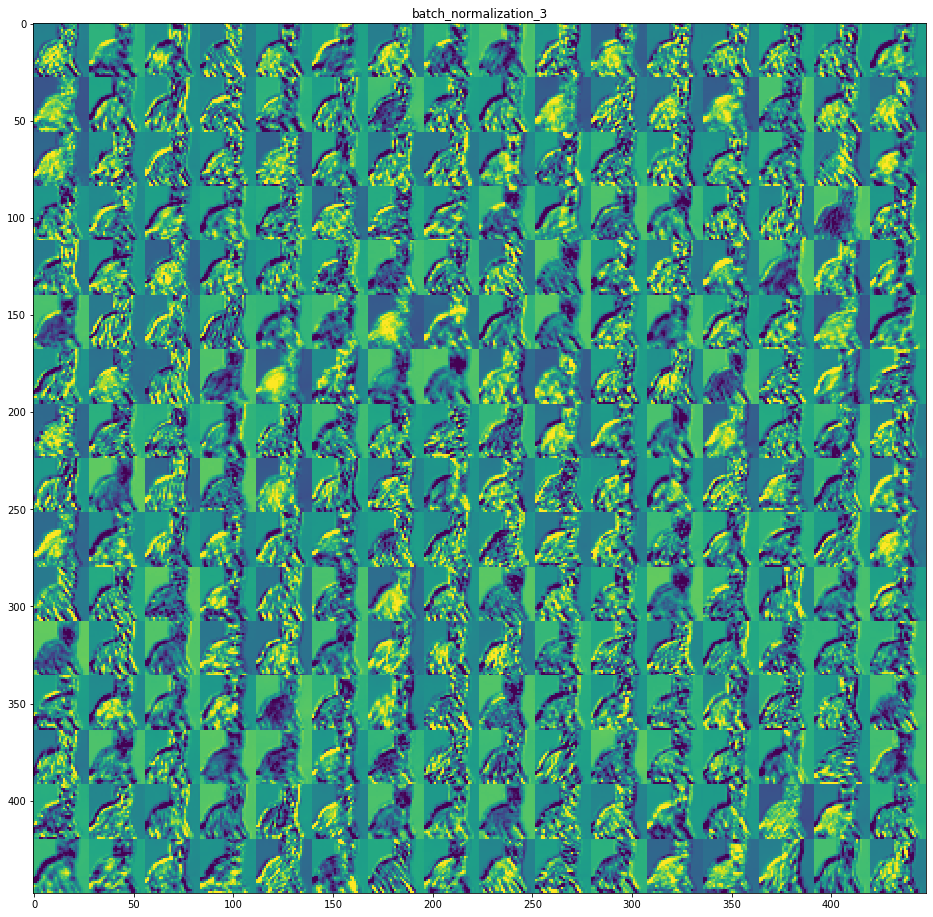

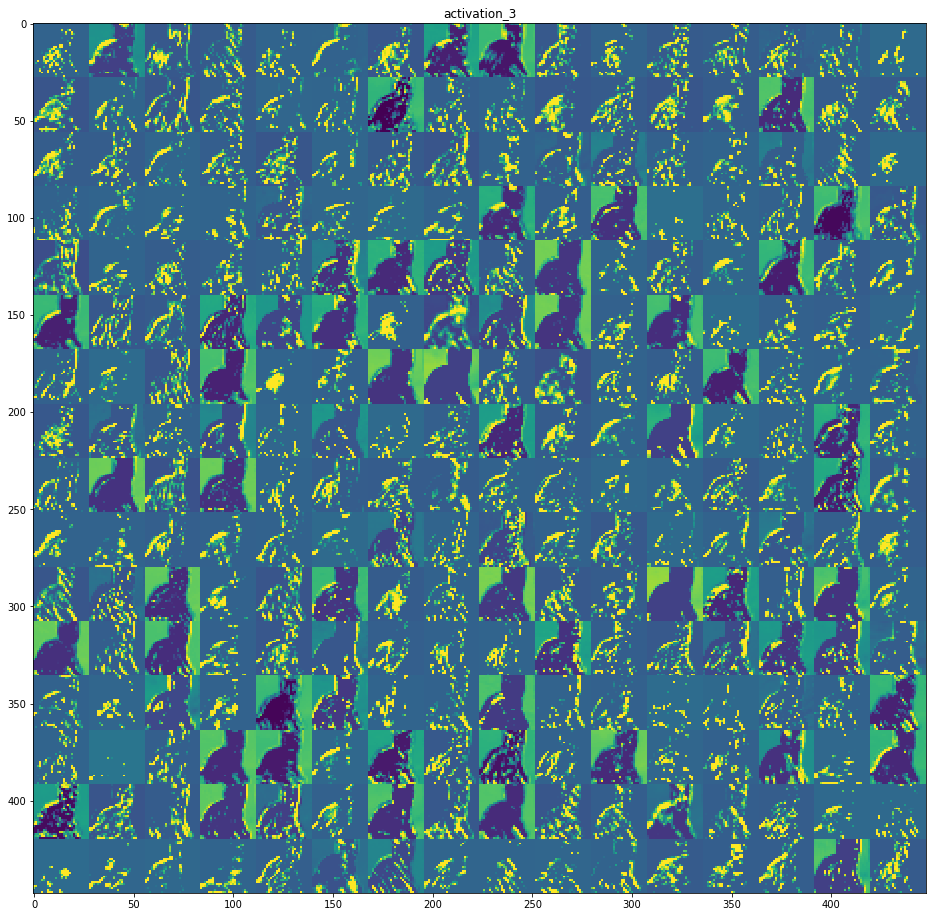

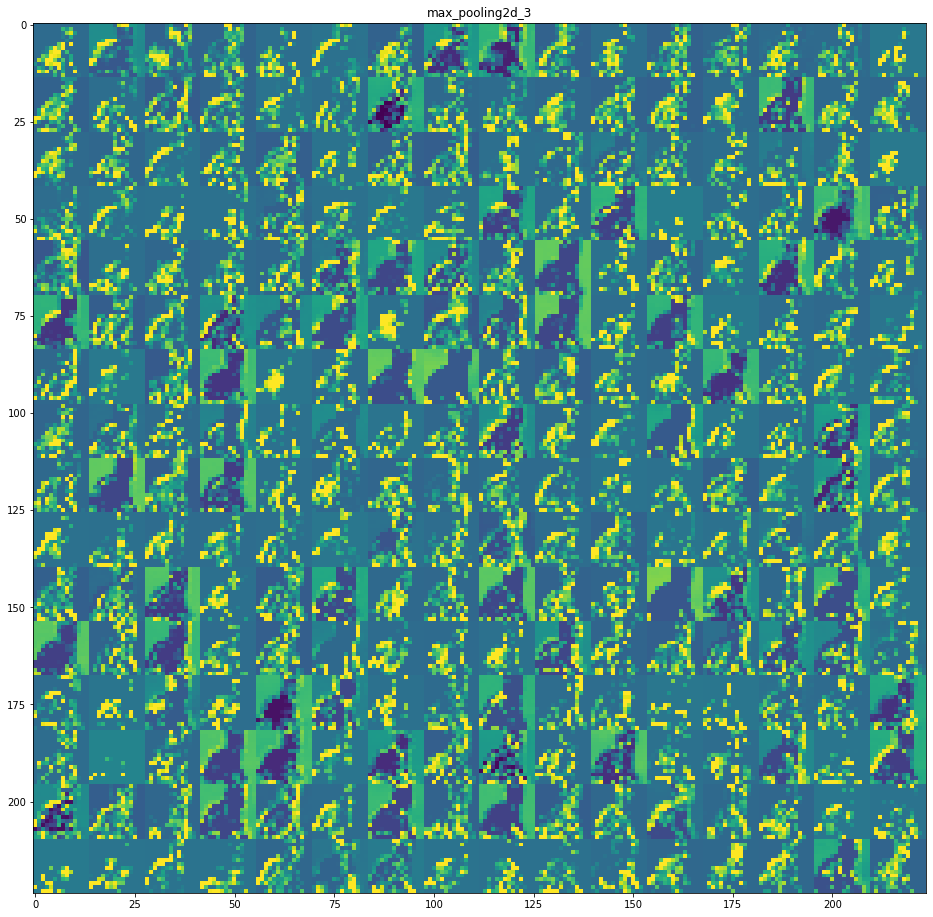

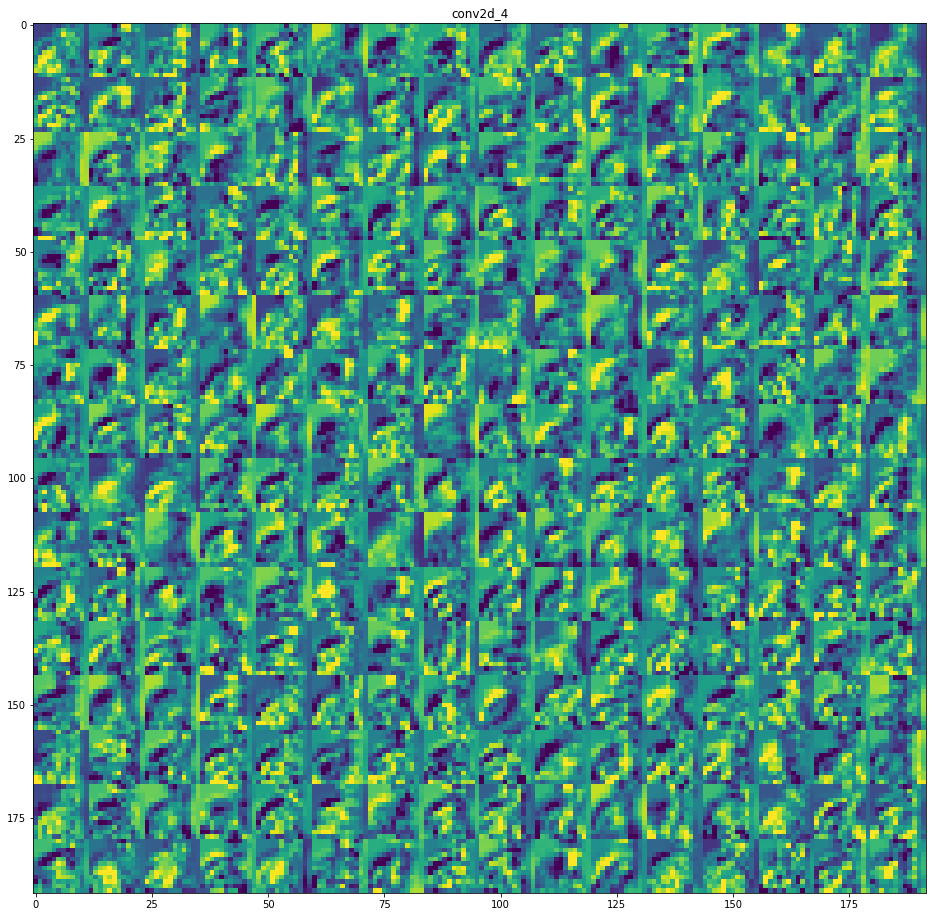

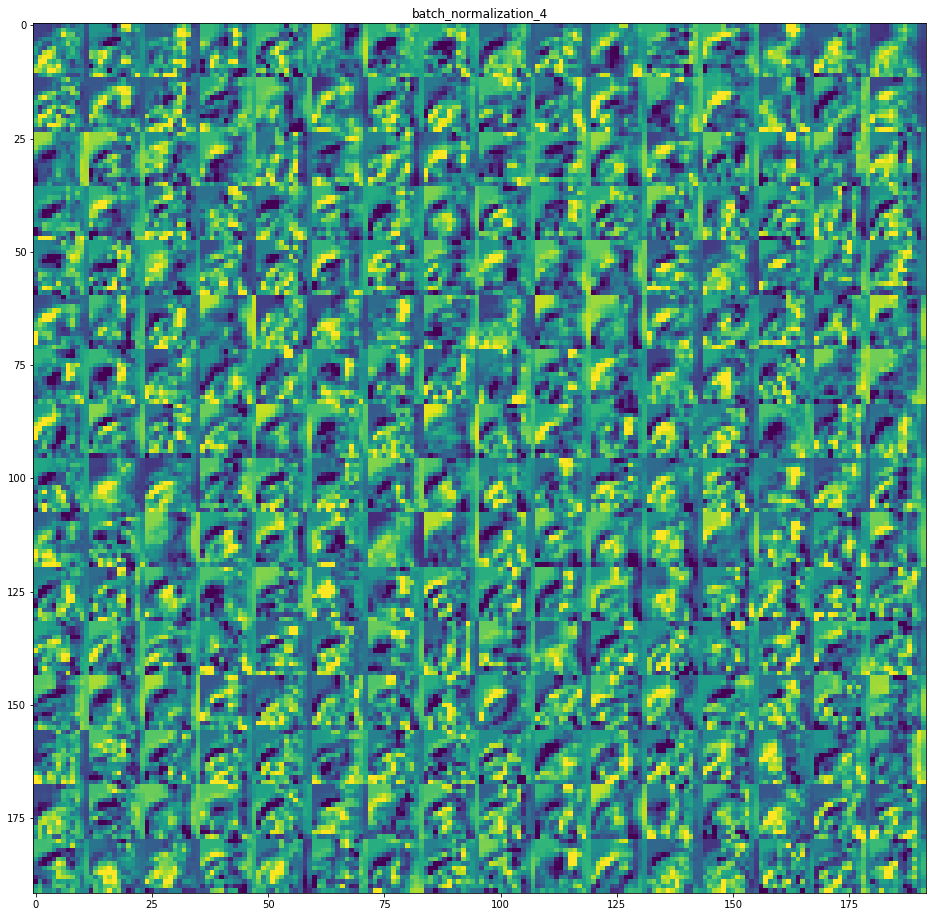

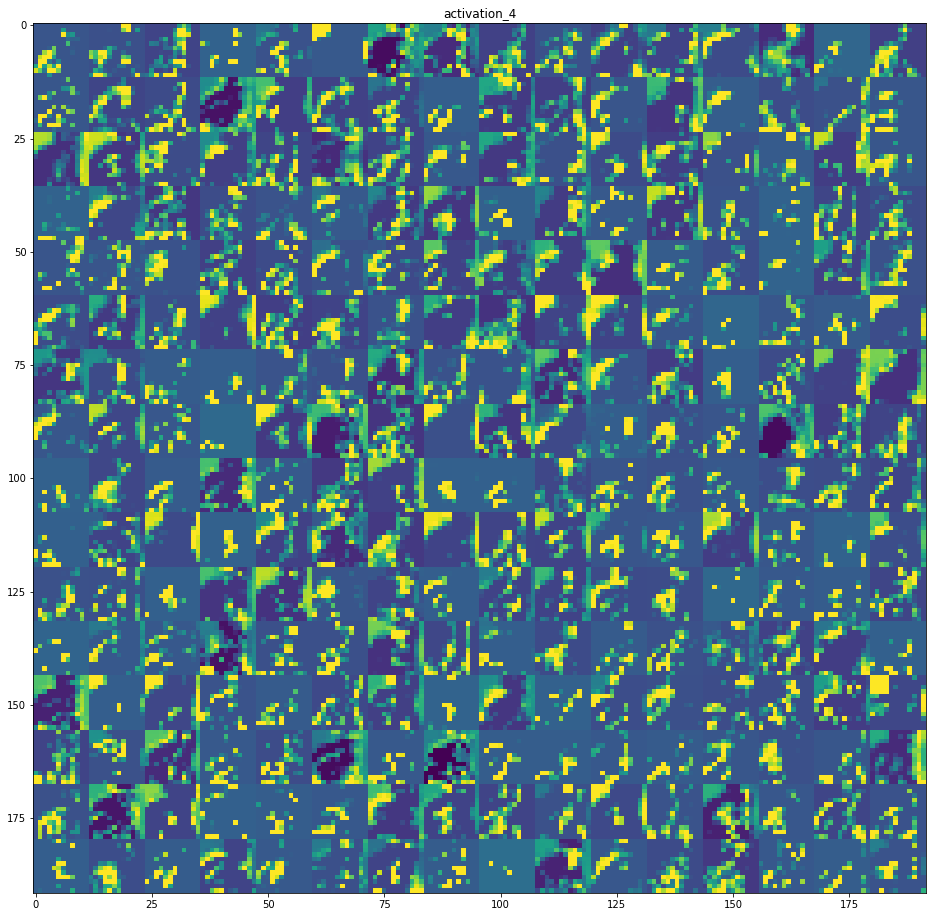

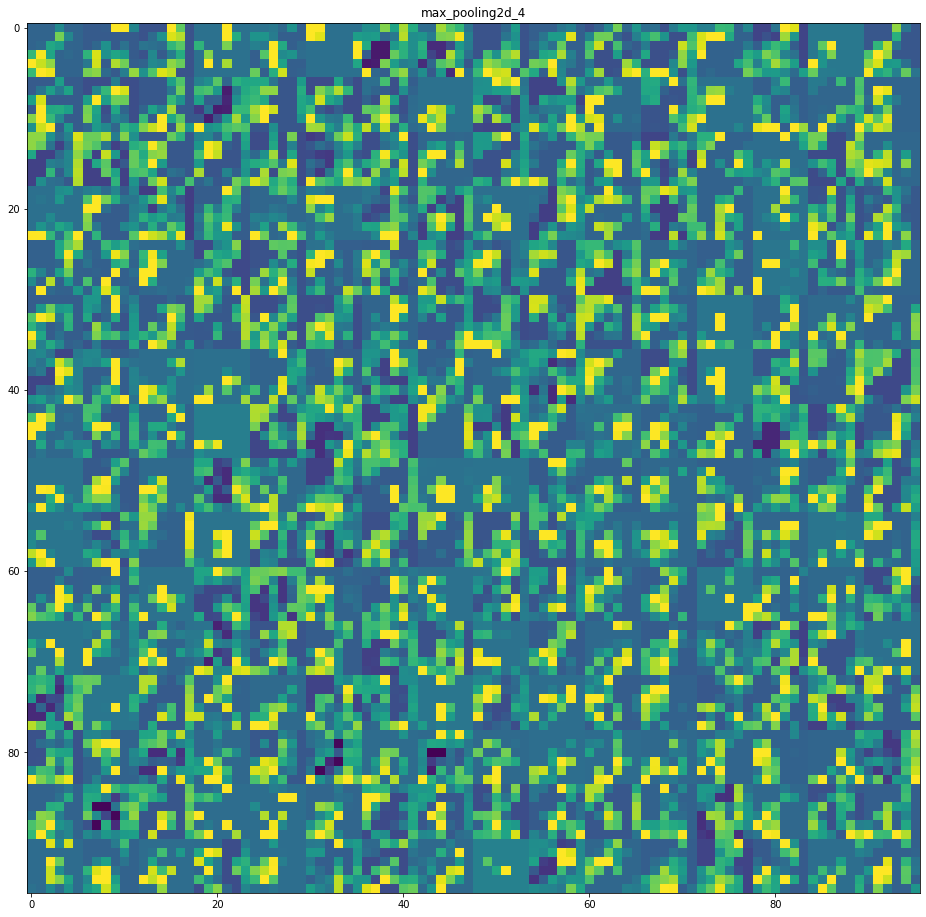

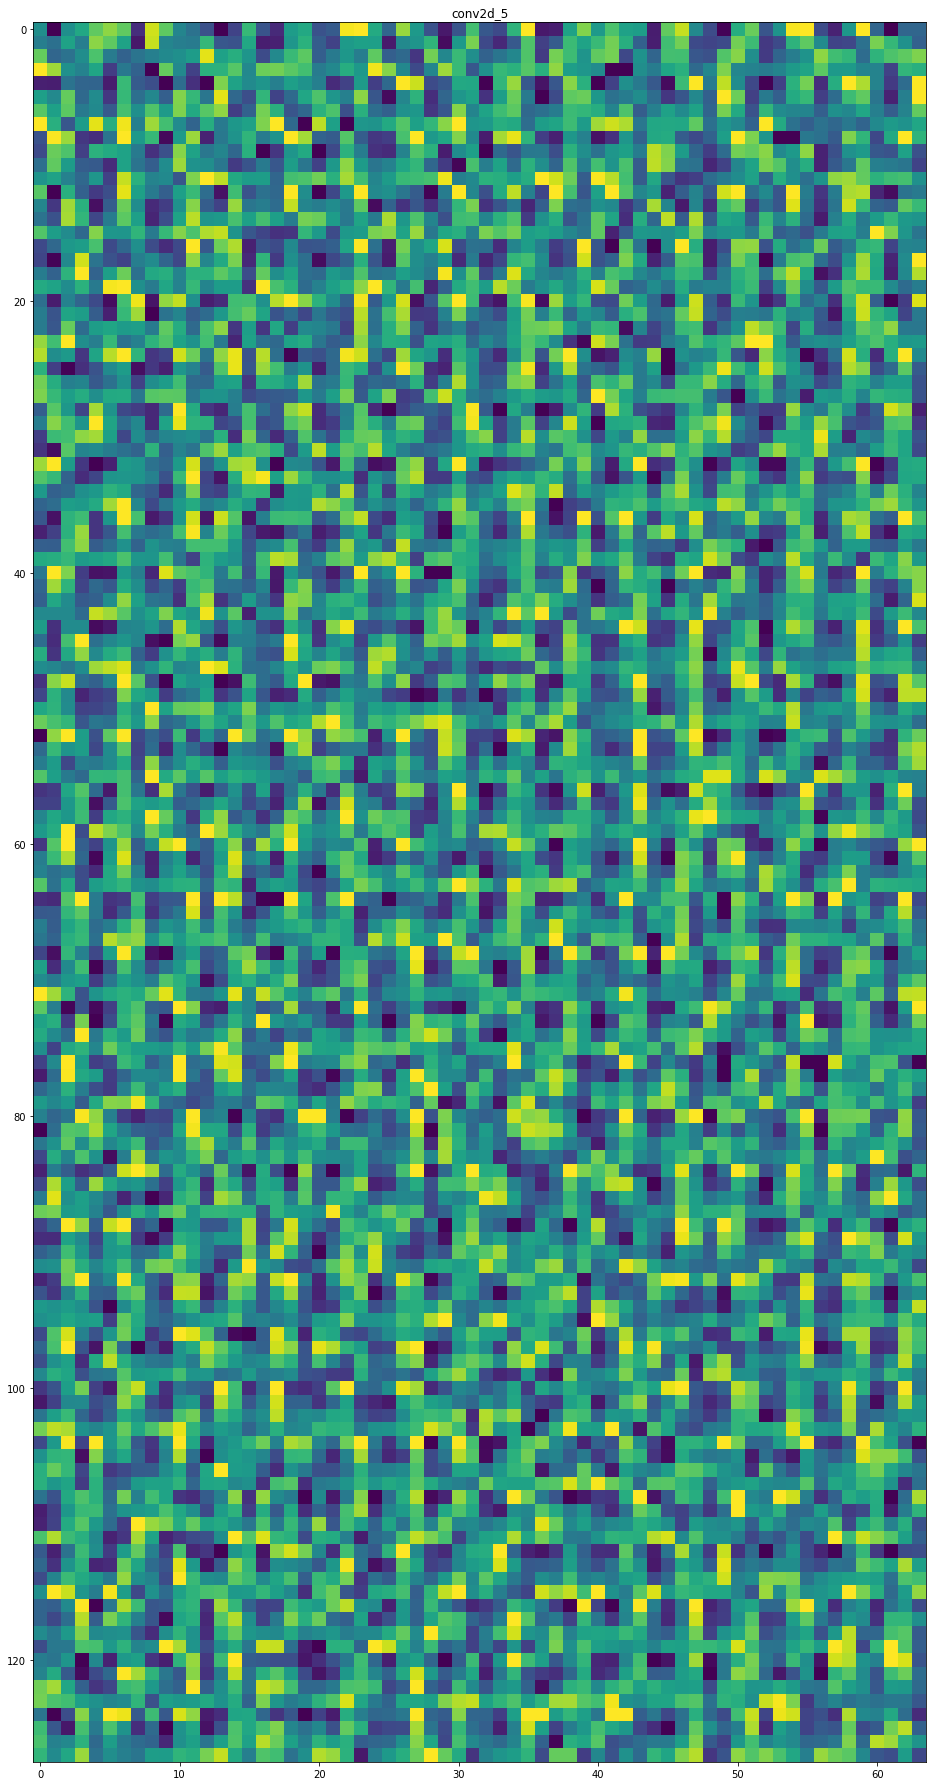

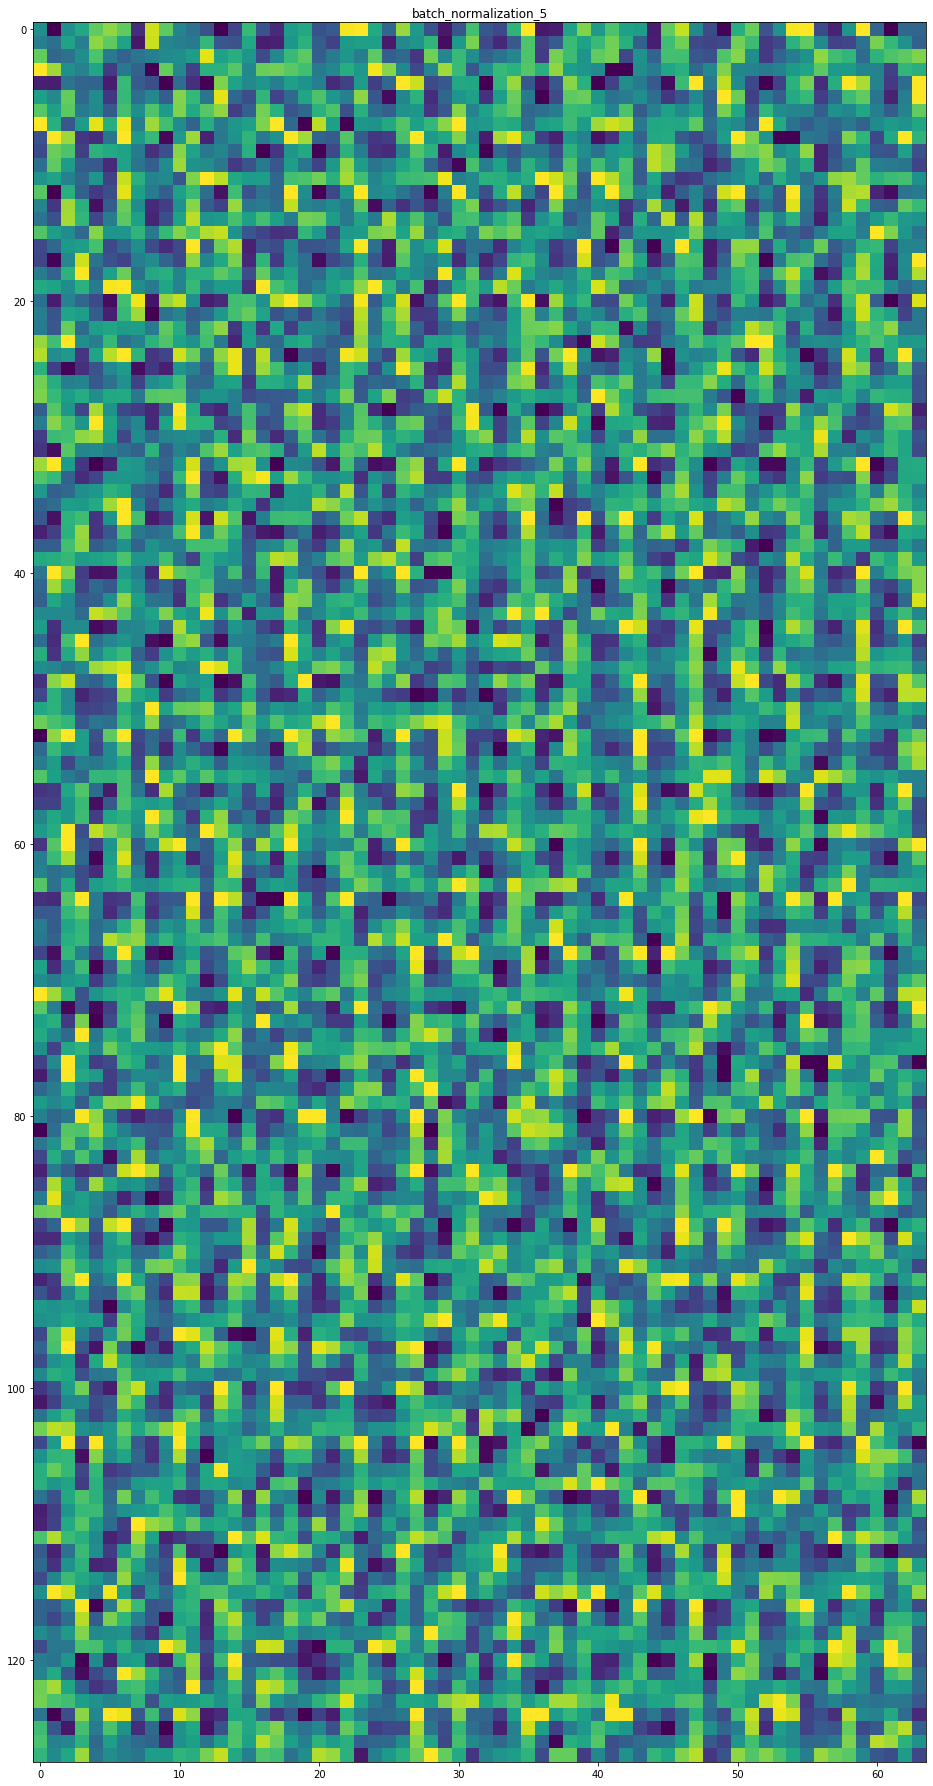

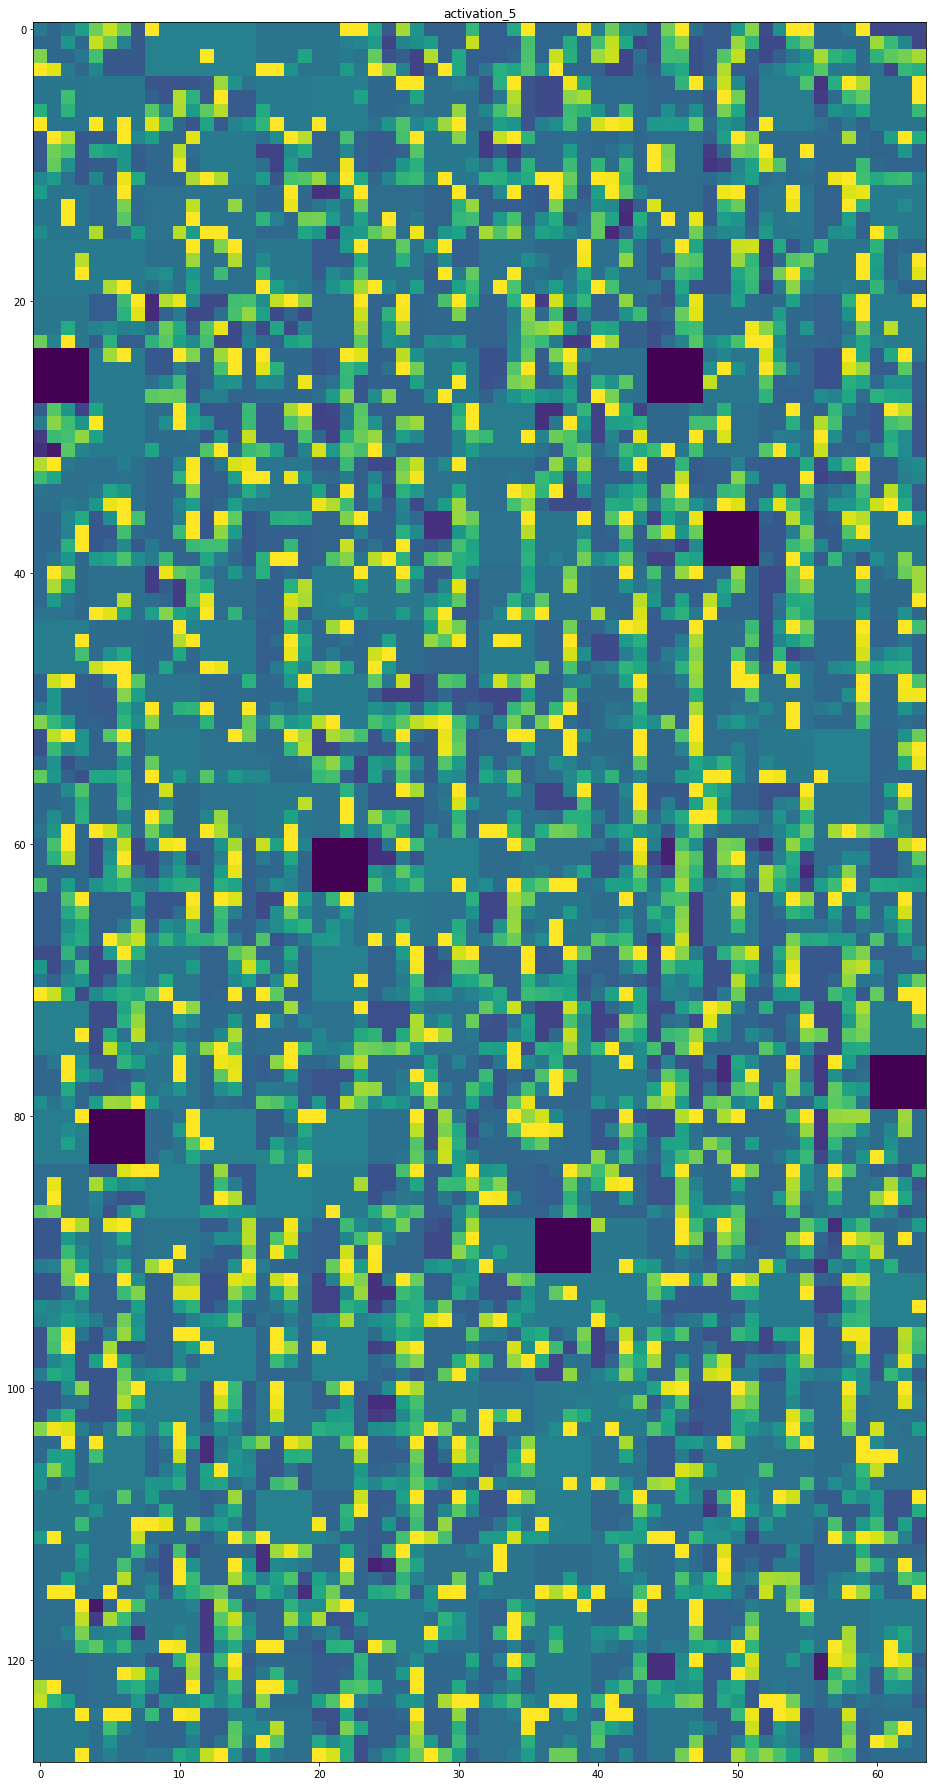

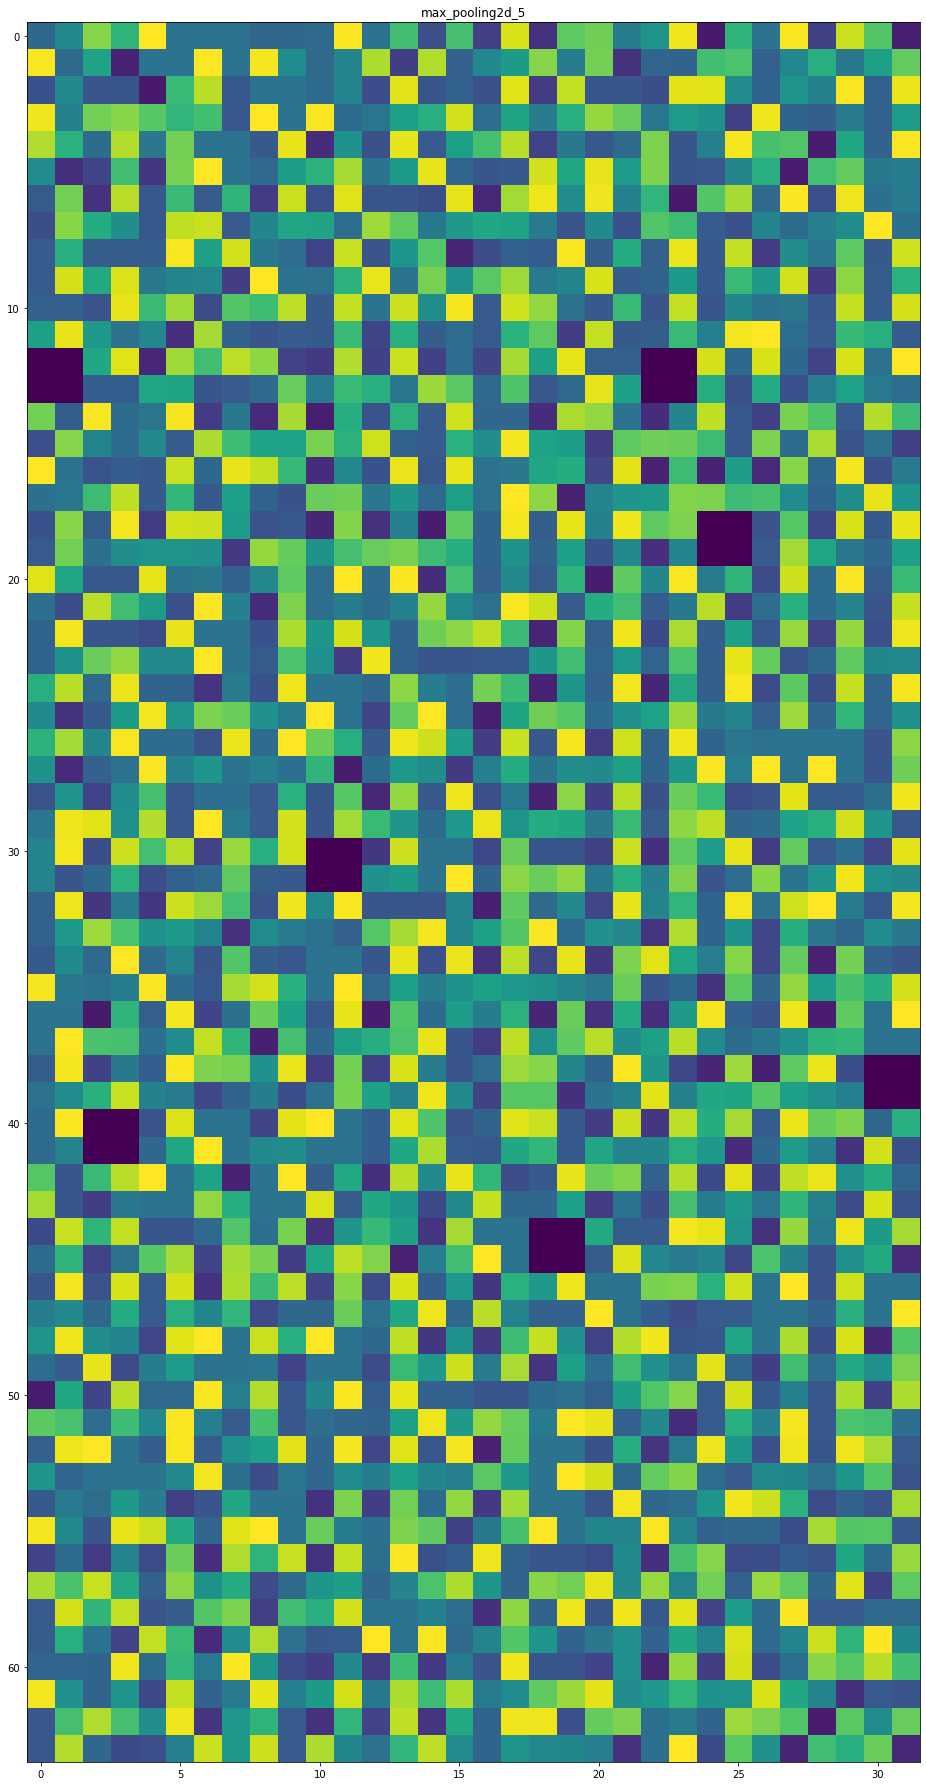

In [20]:
# Code sourced from https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

layer_names = []
for layer in classifier.layers[:20]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')